In [17]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline

backend_inline.set_matplotlib_formats("svg")
from typing import List

In [18]:
class MLP(nn.Module):
    """Construct a MLP resolution for PiNNs

    Args:
        lst: A `List` composed of `int`.
        act: activate function, default = nn.Tanh.
    """

    def __init__(self, lst: List, act=nn.Tanh):
        super().__init__()
        depth = len(lst) - 1
        layers = []
        for i in range(depth - 1):
            layers.append(nn.Linear(lst[i], lst[i + 1]))
            layers.append(act())

        layers.append(nn.Linear(lst[-2], lst[-1]))
        self.layer = nn.Sequential(*layers)

    def forward(self, X):
        return self.layer(X)

In [19]:
model = MLP([1] + [50] * 4 + [1])
model = model.cuda()
model.load_state_dict(torch.load("Best_Shockwave.pt"))
import math

_eps = 1e-6


def _u(x):
    return torch.cos(math.pi * x / 2) * (1 - torch.exp(-2 * x / _eps))


def _u_grad_first_order(x):
    tmp = torch.exp(-2 * x / _eps)
    return (
        -torch.sin(math.pi * x / 2) * math.pi / 2 * (1 - tmp)
        + torch.cos(math.pi * x / 2) * tmp * 2 / _eps
    )


def _u_grad_second_order(x):
    tmp = torch.exp(-2 * x / _eps)
    part1 = math.pi**2 / 4 * (1 - tmp) + tmp * 4 / (_eps**2)
    part2 = 2 * math.pi / _eps * tmp
    return -torch.cos(math.pi / 2 * x) * part1 - torch.sin(math.pi / 2 * x) * part2


def _f_right(x):
    return (x - 2) * _u_grad_first_order(x) - _eps * _u_grad_second_order(x)

In [20]:
x = torch.linspace(0, 1, 1001)
eps = 1e-6
y = torch.cos(torch.pi * x / 2) * (1 - torch.exp(-2 * x / eps))
y_pred = model(x.reshape(-1, 1).cuda()).cpu().detach().numpy().ravel()
rel2 = np.linalg.norm(y - y_pred, 2) / np.linalg.norm(y, 2)
print(rel2)

2.778615e-06


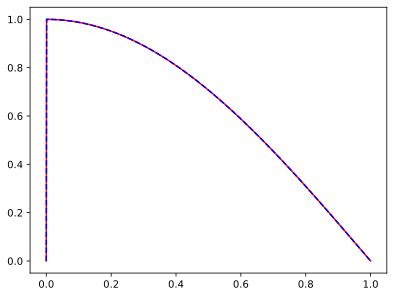

In [21]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

x = torch.linspace(0, 1, 1001)
eps = 1e-6
y = torch.cos(torch.pi * x / 2) * (1 - torch.exp(-2 * x / eps))
y_pred = model(x.reshape(-1, 1).cuda()).cpu().detach().numpy().ravel()
plt.plot(x, y, "r-")
plt.plot(x, y_pred, "b--")
# 显示图像
plt.show()

In [ ]:
ll = []
tt = []
import os

os.chdir("./model_save")

In [7]:
for i in os.listdir():
    if i.endswith(".pt") and "Best" not in i:
        ll.append(i)

In [8]:
ll = sorted(ll, key=lambda x: int(x.split("_")[1].split(".")[0]))

In [9]:
best = 2
for i in ll:
    if i.endswith(".pt"):
        model.load_state_dict(torch.load(i))
        x = torch.linspace(0, 1, 1001)
        eps = 1e-6
        y = torch.cos(torch.pi * x / 2) * (1 - torch.exp(-2 * x / eps))
        y_pred = model(x.reshape(-1, 1).cuda()).cpu().detach().numpy().ravel()
        rel2 = np.linalg.norm(y - y_pred, 2) / np.linalg.norm(y, 2)
        if rel2 < best:
            best = rel2
            torch.save(model.state_dict(), "Best_param.pt")
        print(rel2)
        tt.append(rel2)

0.93078345
0.9275573
0.0070034033
0.008763763
0.88955986
0.8566284
0.8276501
0.80343634
0.7858139
0.7548925
0.75993115
0.7504107
0.74436915
0.00031549396
0.00034982676
0.000110280766
0.0010675244
6.300094e-05
6.184507e-05
5.914099e-05
1.4317232e-05
4.419895e-05
0.00033277445
0.0004076079
0.000814959
0.00031436063
0.0050786613
0.0061731855
0.7203076
0.7227128
0.72172457
0.71854043
0.71843034
0.7180683
0.71372205


In [ ]:
model.load_state_dict(torch.load("Best_Shockwave.pt"))
x = torch.linspace(0, 1, 1001)
eps = 1e-6
y = torch.cos(torch.pi * x / 2) * (1 - torch.exp(-2 * x / eps))
y_pred = model(x.reshape(-1, 1).cuda()).cpu().detach().numpy().ravel()
rel2 = np.linalg.norm(y - y_pred, 2) / np.linalg.norm(y, 2)

print(rel2)

2.7782291e-06


Error u: 2.788189e-06


/tmp/ipykernel_8792/617660828.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x_test.reshape(-1, 1), dtype=torch.float32).cuda(),
/tmp/ipykernel_8792/617660828.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(


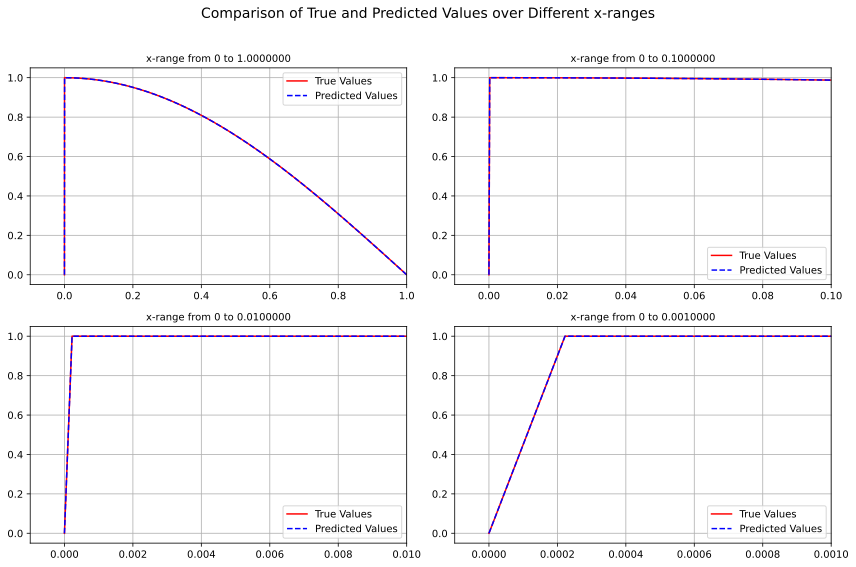

In [ ]:
x_test = torch.linspace(0, 1, 4501)
y_true = torch.cos(torch.pi * x_test / 2) * (1 - torch.exp(-2 * x_test / eps))
y_true = y_true.ravel()

y_pred = (
    model(
        torch.tensor(
            torch.tensor(x_test.reshape(-1, 1), dtype=torch.float32).cuda(),
            dtype=torch.float32,
        ).cuda()
    )
    .cpu()
    .detach()
    .numpy()
    .ravel()
)

error_u = np.linalg.norm(y_true - y_pred, 2) / np.linalg.norm(y_true, 2)

print("Error u: %e" % (error_u))
import matplotlib.pyplot as plt

# 创建一个包含2行3列子图的画布
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
x_ranges = [0.1**i for i in range(4)]

for i, ax in enumerate(axs.flatten()):
    ax.plot(x_test, y_true, "r-", label="True Values")
    ax.plot(x_test, y_pred, "b--", label="Predicted Values")
    ax.set_xlim(-x_ranges[i] * 0.1, x_ranges[i])
    ax.set_title(f"x-range from 0 to {x_ranges[i]:.7f}", fontsize=10)
    ax.legend()
    ax.grid(True)
fig.suptitle(
    "Comparison of True and Predicted Values over Different x-ranges", fontsize=14
)

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("Comparison of True and Predicted Values over Different x-ranges.png")
plt.show()

/tmp/ipykernel_8792/4019284078.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model(torch.tensor(x.reshape(-1, 1), dtype=torch.float32).cuda())


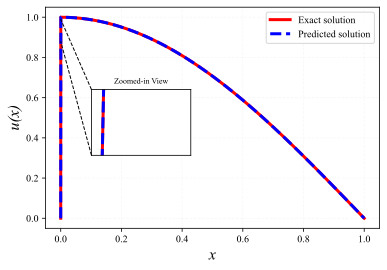

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

plt.rcParams["font.family"] = "Times New Roman"

# 生成数据
x = torch.linspace(0, 1, 4501)
eps = 1e-6
y = torch.cos(torch.pi * x / 2) * (1 - torch.exp(-2 * x / eps))

# 计算预测值
y_pred = (
    model(torch.tensor(x.reshape(-1, 1), dtype=torch.float32).cuda())
    .cpu()
    .detach()
    .numpy()
    .ravel()
)

x = x.numpy()
y = y.numpy()

# 创建主图
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, "r-", label="Exact solution", linewidth=3)
ax.plot(x, y_pred, "b--", label="Predicted solution", linewidth=3)
font_dict = dict(
    fontsize=16,
    color="k",
    family="Times New Roman",
    weight="light",
    style="italic",
)
ax.set_xlabel("x", fontdict=font_dict)
ax.set_ylabel("u(x)", fontdict=font_dict)
ax.legend()
ax.grid(True, linestyle="--", alpha=0.1)
x_min, x_max = 0.000, 0.00015
y_min, y_max = 0.7, 0.9
# 放大区域的 x, y 范围
x_range = (0.0, 0.0018)
y_range = (0.88, 0.99)
rect = patches.Rectangle(
    (x_min, y_min),
    x_max - x_min,
    y_max - y_min,
    linewidth=1.5,
    edgecolor="black",
    linestyle="--",
    facecolor="none",
)
ax.add_patch(rect)
# 创建放大子图（inset_axes）
axins = inset_axes(
    ax,
    width="35%",
    height="35%",
    bbox_to_anchor=(-0.4, -0.2, 0.85, 0.85),
    bbox_transform=ax.transAxes,
)  # 子图大小与位置
axins.plot(x, y, "r-", linewidth=3)
axins.plot(x, y_pred, "b--", linewidth=3)
axins.set_xlim(x_range)
axins.set_ylim(y_range)
axins.set_xticks([])
axins.set_yticks([])
# axins.set_xticks([1e-3, 1.5e-3])
# axins.set_yticks([0.88, 0.9])

axins.grid(True, linestyle="--", alpha=0.1)
axins.set_title("Zoomed-in View", fontsize=8)

# 添加子图的边框，使其更加突出
axins.spines["top"].set_color("black")
axins.spines["right"].set_color("black")
axins.spines["left"].set_color("black")
axins.spines["bottom"].set_color("black")
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="black", linestyle="--")
# 显示图像
plt.savefig("Ours.pdf")
plt.show()